In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def detect_plants_with_circles(image_path, threshold):
    # load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # change color from rgb to hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # define green range (may need to be adjusted)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)

    # morphological filter (noise removal)
    kernel = np.ones((5,5), np.uint8)
    mask_clean = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)
    mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_CLOSE, kernel)

    # find contours
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"Anzahl gefundener Konturen: {len(contours)}")

    # copy image to show recognized plants with circles
    img_rects = img_rgb.copy()

    # array of centers of circles
    circles = []

    for cnt in contours:
        area = cv2.contourArea(cnt)

        if area > threshold:  
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            center = (int(x), int(y))
            radius = int(radius)
            circles.append((center, radius))
            cv2.circle(img_rects, center, radius, (0, 0, 255), 5)

    # show partial results
    print(f"Pflanzenkonturen mit Threshold: {threshold}")
    
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Grün Maske")
    plt.imshow(mask_clean, cmap='gray')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Erkannte Pflanzen")
    plt.imshow(cv2.cvtColor(img_rects, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()

    return circles

In [ ]:
import os
import cv2
import numpy as np
from shapely.geometry import Point, LineString

def detect_plant_rows(img_path, output_path = None):
    output_specified = output_path is not None
    if output_specified:
        os.makedirs(output_path, exist_ok=True)

    # parameter for Hough-Transformation
    minLineLength = 0
    thresholdHoughLines = 10
    maxLineGap = 10000

    # parameter for filtering
    minAngle = 85
    maxAngle = 95
    
    
    # Intersection check const
    maxDistanceToLine = 50

    lineArea = 300

    # find green contours and the center of their surrounding circle
    # at this point primarily large plants (crops) are added to the circles array
    circles = detect_plants_with_circles(img_path, 5000)

    imgOutput = cv2.imread(img_path)
    height, width = imgOutput.shape[:2]
    x_center = width // 2

    # create empty image
    imgHoughTransformation = np.zeros((height, width), dtype=np.uint8)

    # add center of circles 
    print(f"\n Zeichne {len(circles)} crop circles")
    for center, radius in circles:
        cv2.circle(imgHoughTransformation, center, radius=10, color=255, thickness=5)
        
    # use Hough-Line-Transformation
    lines = cv2.HoughLinesP(imgHoughTransformation, rho=1, theta=np.pi/180, threshold=thresholdHoughLines, minLineLength=minLineLength, maxLineGap=maxLineGap)
    #add weeds by adding a low threshold value no matter the crop contours
    circles = detect_plants_with_circles(img_path, 100)
    # calculate boundary of circles
    # buffer creates a circular polygon approximation around the center point using given radius
    circlesWithBoundary = [(Point(center), Point(center).buffer(radius).boundary) for center, radius in circles]

    if lines is None:
        withIntersections = []
        noIntersections = circles
    else:
        # visualize the lines of the crops
        out = np.zeros((len(lines), len(circles)), dtype=bool)

        for j, line in enumerate(lines):
            x1, y1, x2, y2 = line[0]
            dx = x2 - x1
            dy = y2 - y1
            theta = np.arctan2(dy, dx)  # angle of lines in radians

            angle_deg = abs(np.degrees(theta))  # only positive angles

            # norm angles to [0°, 180°]
            if angle_deg > 180:
                angle_deg -= 180

            # only approx. vertical lines
            if minAngle <= angle_deg <= maxAngle:

                # only lines in the center of the image are relevant
                if (abs(x1 - x_center) <= lineArea) or (abs(x2 - x_center) <= lineArea):
                    cv2.line(imgOutput, (x1, y1), (x2, y2), (0, 0, 255), 5)

                    # convert to LineString for calculating intersections
                    lsLine = LineString([(x1, y1), (x2, y2)])
                    for i, (center, boundary) in enumerate(circlesWithBoundary):
                        dist = lsLine.distance(Point(center))
                        out[j, i] = dist < maxDistanceToLine or lsLine.intersects(boundary)

        # get coordinates of intersecting and non-intersecting circles
        circleIntersections = out.any(axis=0)

        withIntersections = [circles[i] for i in np.where(circleIntersections)[0]]
        noIntersections = [circles[i] for i in np.where(~circleIntersections)[0]]
        
    print(f"{len(withIntersections)} intersecting circles (-> crops) found.\n\n")
    print("Centers of intersecting circles (-> crops): \n", withIntersections, "\n\n")
    print(f"{len(noIntersections)} non-intersecting circles (-> weeds) found.\n\n")
    print("Centers of non-intersecting circles (-> weeds):\n", noIntersections, "\n\n")
    
    if output_specified:
        # add circles 
        print(f"\n Zeichne {len(noIntersections)} weed circles")
        for weed in noIntersections:
            cv2.circle(imgOutput, weed[0], radius=weed[1], color=(255, 0, 0), thickness=5)
        print(f"\n Zeichne {len(withIntersections)} crop circles")
        for crop in withIntersections:
            cv2.circle(imgOutput, crop[0], radius=crop[1], color=(0, 255, 0), thickness=5)

        cv2.imwrite(os.path.join(output_path, os.path.basename(img_path)), imgOutput)

    return (withIntersections, noIntersections)

img_path: 2_dataset/images/corn/IMG_4003.png
Anzahl gefundener Konturen: 45
Pflanzenkonturen mit Threshold: 5000


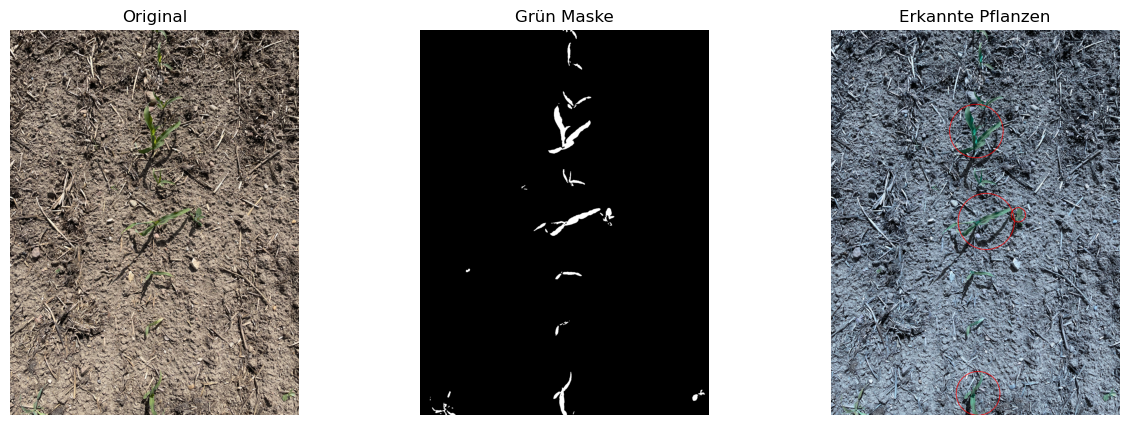


 Zeichne 4 crop circles
Anzahl gefundener Konturen: 45
Pflanzenkonturen mit Threshold: 100


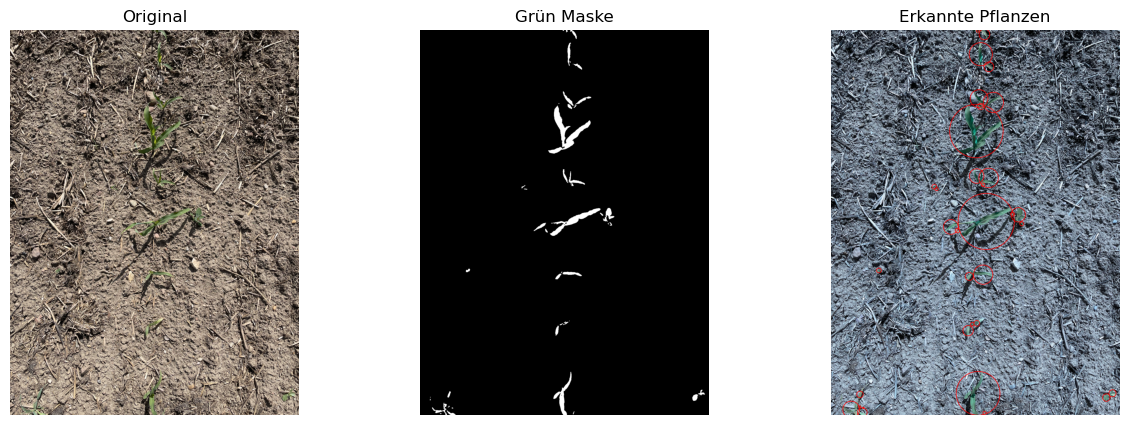

5 intersecting circles (-> crops) found.


Centers of intersecting circles (-> crops): 
 [((1539, 3805), 229), ((1525, 3072), 30), ((1592, 2562), 101), ((1624, 2005), 294), ((1521, 1058), 280)] 


29 non-intersecting circles (-> weeds) found.


Centers of non-intersecting circles (-> weeds):
 [((1607, 4009), 17), ((327, 4007), 51), ((339, 3958), 8), ((300, 3946), 12), ((211, 3975), 88), ((2881, 3849), 39), ((303, 3816), 34), ((2945, 3804), 37), ((1434, 3149), 54), ((1478, 3081), 19), ((1447, 2580), 42), ((501, 2518), 25), ((1322, 2101), 23), ((1254, 2062), 77), ((1996, 2030), 21), ((1900, 1928), 21), ((1960, 1935), 75), ((1104, 1666), 17), ((1081, 1640), 25), ((1591, 1620), 19), ((1649, 1549), 102), ((1524, 1529), 76), ((1567, 801), 33), ((1699, 758), 106), ((1549, 718), 93), ((1652, 385), 51), ((1567, 253), 121), ((1605, 46), 56), ((1535, 10), 13)] 



 Zeichne 29 weed circles

 Zeichne 5 crop circles
img_path: 2_dataset/images/corn/3974.png


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
from pathlib import Path

# input/output path
output_path = 'output'
img_paths = Path('dataset/images').glob('*/*.png')

for img_path in img_paths:
    print(f"img_path: {img_path}")
    crop_coords, weed_coords = detect_plant_rows(img_path, output_path)